In [72]:
# %matplotlib widget
%matplotlib inline

In [76]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# State tomography analysis functions

Measurement occurs along 3 axes, each of which can give one of 2 values:

Z, X, Y -> {0, 1}

In [4]:
meas_order = np.array(['Z', 'X', 'Y'])
calib_order = np.array(['g', 'e'])

## Getting rho from meas counts

First random helper method stuff for pauli matrices and dealing with the measurement order

In [5]:
def pauli(i): return [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()][i]

def s2i(s): # string to pauli matrix index
    return int(np.char.find('IXYZ', s))

def i2s(i): # pauli matrix index to string
    return 'IXYZ'[i]

def order(S): # given a pauli matrix name, get the index at which it (or equivalent data) was measured
    assert S in 'IXYZ'
    # for the purposes of getting counts, measuring in I basis and Z basis are interchangeable
    if S == 'I': S = 'Z'
    return np.argwhere(meas_order == S)[0][0]
# print(order('X'))

In [6]:
"""
Define basis in to be used when doing MLE
"""
# 2 cardinal points on Bloch sphere for each measurement axis
# psiZ = [qt.basis(3,0), qt.basis(3,1)]
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi = dict(Z=psiZ, X=psiX, Y=psiY)

psi_basis = dict() # 6 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
for S in meas_order:
    psi0 = psi[S]
    psi_basis.update({S:[]})

    psi_basis[S].append(psi0[0]) # g
    psi_basis[S].append(psi0[1]) # e

Convert single shot measurements into counts for each of the 9 measurement axes: 4x9=36 elements in the count array, then into the initial rho from experiment which will likely be unphysical.

In [7]:
"""
n should be length 2 array containing single shot counts of measuring 0, 1 for measurement along axes i, j
Converts n to Tij for use in the T^\dag T = rho matrix where measurement axes are S: I, X, Y, Z
"""
def Tij(n, S):
    assert 0 <= S <= 3 # S1, S2 represent pauli matrix indices
    signs = [1]*2
    # eigenvalues of X, Y, Z are +/- 1, eigenvalues of I are +1
    if S > 0: signs[1] *= -1
    return np.sum(np.multiply(signs, n))


In [10]:
"""
Construct rho by adding together Tij for each of the 4 Pauli matrices
"""
def rho_from_counts(n):
    rho = 0*qt.qeye(2)
    for i in range(4): # loop over pauli matrices for qubit 1
        o = order(i2s(i)) # get the right 2 elements in the n matrix
        rho += Tij(n[2*o:2*(o+1)], i) * pauli(i)
    rho = rho.unit() # normalize
    rho = rho.tidyup(1e-10) # remove small elements
    rho = rho.full()
    return rho

### Generate test data

In [11]:
def generate_counts(qubits, rho_id, n_tot, noise=1.0):
    n = []
    for S in meas_order:
        for psi0 in psi_basis[S]:
            # measure in psi basis
            n.append(n_tot * (psi0 * psi0.dag() * rho_id).tr())
    n = np.reshape(np.array(n), (len(psi_basis.keys()), 4))

    # introduce gaussian noise
    for n_psi in n:
        n_meas = sum(n_psi)
        new_n1 = -1
        while new_n1 < 0:
            new_n0 = np.random.normal(loc=n_psi[0], scale=noise*np.sqrt(n_psi[0]))
            # preserve original total count per measurement
            new_n1 = n_meas - sum(new_n0)
        n_psi[0] = np.round(new_n0)
        n_psi[1] = np.round(new_n1)
    return n

### Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

maybe need to do something about fixing negative counts, but for now I will not. it should be automatically resolved in the MLE.

In [12]:
def correct_readout_err(n, n_conf):
    conf_mat = np.array(n_conf, dtype=float)
    for r, row in enumerate(conf_mat):
        conf_mat[r] /= sum(row) # normalize so counts for each state prep sum to 1
    conf_mat = np.transpose(conf_mat) # want counts for each state prep on columns
    conf_mat_inv = np.linalg.inv(conf_mat)
    # C_id = invM . C_noisy
    n = np.array(n, dtype=float)
    for r in range(len(n)):
        n[r] = (conf_mat_inv @ n[r].T).T
    return np.around(n, decimals=5)

In [13]:
def fix_neg_counts(counts):
    counts = np.array(counts)
    assert len(counts.shape) == 2 # 2d array

    for i_n, n in enumerate(counts):
        while len(n[n<0]) > 0: # repeat while still has neg counts
            assert sum(n) > 0, 'Negative sum of counts'
            neg_indices = np.where(n<0)[0]
            neg_vals = n[n<0]
            len_pos = len(n) - len(neg_vals)
            n += sum(neg_vals)/len_pos # redistribute the negative counts over all the positive elements evenly
            for i in neg_indices:
                n[i] = 0

        counts[i_n] = np.round(n)
    return counts

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions

In [14]:
# Modification of np.diag_indices to allow off diagonal entries
# n = dim, k < 0 = lower diagonals, k > 0 = upper diagonals
def diag_indices_k(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0: return rows[-k:], cols[:k]
    elif k > 0: return rows[:-k], cols[k:]
    else: return rows, cols

def T_flat2mat(t):
    # T_mat = []
    # T_mat.appen(np.array([t[0],           0,              0,               0]))
    # T_mat.append(np.array([t[4] +1j*t[5],  t[1],           0,               0]))
    # T_mat.append(np.array([t[10]+1j*t[11], t[6]+1j*t[7],   t[2],            0]))
    # T_mat.append(np.array([t[14]+1j*t[15], t[12]+1j*t[13], t[8]+1j*t[9], t[3]]))
    d = int(np.sqrt(len(t)))
    t_complex = np.zeros(int(d + (len(t)-d)/2), dtype=complex)
    t_complex[:d] = t[:d]
    for i in range(d, len(t_complex)):
        t_complex[i] = t[d + (i-d)*2] + 1j*t[d + (i-d)*2 + 1]
    T_mat = np.zeros(shape=(d,d), dtype=complex)
    start_i = 0
    for k in range(d):
        T_mat[diag_indices_k(T_mat, -k)] = t_complex[start_i:start_i+(d-k)]
        start_i += d - k
    return np.array(T_mat)


Not using these!


This is taken from [James et al. 2001](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.052312), eq. 4.6.

In [15]:
# def det_ij(rho, i, j):
#     M = np.delete(rho, i, axis=0)
#     M = np.delete(M, j, axis=1)
#     return np.linalg.det(M)

# def det_ijkl(rho, i, j, k, l):
#     M = np.delete(rho, [i,k], axis=0)
#     M = np.delete(M, [j,l], axis=1)
#     return np.linalg.det(M)

# def t_from_rho_unused(rho):
#     t = []
#     det = np.linalg.det(rho)
#     det00 = det_ij(rho, 0, 0)
#     det01 = det_ij(rho, 0, 1)
#     det0011 = det_ijkl(rho, 0, 0, 1, 1)
#     det0012 = det_ijkl(rho, 0, 0, 1, 2)
#     det0112 = det_ijkl(rho, 0, 1, 1, 2)
#     # ensure no divide by 0 errors since this algo is intended for positive definite matrices
#     if det == 0: det = 1e-10
#     if det00 == 0: det00 = 1e-10
#     if det0011 == 0: det0011 = 1e-10
#     if det0012 == 0: det0012 = 1e-10
#     if det0112 == 0: det0112 = 1e-10
#     rho33 = rho[3,3]
#     if rho33 == 0: rho33 = 1e-10
#     t = [np.sqrt(det/det00), np.sqrt(det00/det0011), np.sqrt(det0011/rho33), np.sqrt(rho[3,3])]
#     t56 = det01/np.sqrt(det00*det0011)
#     t.extend([np.real(t56), np.imag(t56)])
#     t78 = det0012/np.sqrt(rho33*det0011)
#     t.extend([np.real(t78), np.imag(t78)])
#     t910 = rho[3,2]/np.sqrt(rho33)
#     t.extend([np.real(t910), np.imag(t910)])
#     t1112 = det0112/np.sqrt(rho33*det0011)
#     t.extend([np.real(t1112), np.imag(t1112)])
#     t1314 = rho[3,1]/np.sqrt(rho33)
#     t.extend([np.real(t1314), np.imag(t1314)])
#     t1516 = rho[3,0]/np.sqrt(rho33)
#     t.extend([np.real(t1516), np.imag(t1516)])
#     assert(len(t)==16)
#     return np.real(np.array(t)) # take the real since rho may be slightly non-positive semi definite, so det(rho) may be slightly negative

# def rho_from_t_unused(t):
#     T = T_flat2mat(t)
#     rho = T.conj().T @ T
#     return rho / np.trace(rho)

Using this.

Cholesky-Banachiewicz algorithm - valid for positive definite matrices, so need to ensure no divide by 0 errors. I think this actually works better than the James et al method?

In [16]:
def t_from_rho(rho):
    t = []
    T = np.zeros(shape=np.shape(rho))
    d = np.shape(rho)[0]
    for i in range(d):
        for j in range(i+1):
            sum = 0
            for k in range(j):
                sum += T[i, k] * T[j, k]
            if i == j: T[i, i] = np.sqrt(rho[i, i] - sum)
            else:
                Tjj = T[j, j]
                if Tjj == 0: Tjj = 1e-10
                T[i, j] = (rho[i, j] - sum) / Tjj
    t = np.diagonal(T)
    for k in range(1, d):
        t_complex = np.diag(T, k=-k)
        for t_i in t_complex:
            t = np.append(t, [np.real(t_i), np.imag(t_i)])
    return np.real(t)
    
def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T @ T.conj().T
    return rho / np.trace(rho)

### MLE functions

In [17]:
def run_MLE(n, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    # psi_basis = get_psi_basis(qubits)
    psi_basis_flat = []
    for S in meas_order:
        for psi in psi_basis[S]:
            # measure in psi basis
            psi_basis_flat.append(psi)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis_flat, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return np.log(val)
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    # print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

# Plotting functions

In [89]:
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title, fontsize=24)
    plt.imshow(np.real(mat), cmap='RdBu')
    plt.xticks(np.arange(len(mat)), labels, fontsize=24)
    plt.yticks(np.arange(len(mat)), labels, fontsize=24)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=22)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[-cmax, 0, cmax])
    cbar.ax.tick_params(labelsize=20)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None, title=None, cmax=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    labels = ["0", "1"]
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 12))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title, fontsize=24)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_MLE), np.imag(rho_MLE), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    plt.show()

In [19]:
# Author: Ziqian
def show_plot_rho_3d(rho_MLE, rho_id=None):
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
    else:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')
        ax3 = fig.add_subplot(223, projection='3d')
        ax4 = fig.add_subplot(224, projection='3d')
    
    labels = ["0", "1"]
    qplt.matrix_histogram(np.real(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax1)
    qplt.matrix_histogram(np.imag(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax2)
    if rho_id is not None:
        qplt.matrix_histogram(np.real(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax3)
        qplt.matrix_histogram(np.imag(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax4)
    
    ax1.view_init(azim=-55, elev=45)
    ax2.view_init(azim=-55, elev=45)
    ax1.set_title("Re[$\\rho_{MLE}$]")
    ax2.set_title("Im[$\\rho_{MLE}$]")
    if rho_id is not None:
        ax3.view_init(azim=-55, elev=45)
        ax4.view_init(azim=-55, elev=45)
        ax3.set_title("Re[$\\rho_{ideal}$]")
        ax4.set_title("Im[$\\rho_{ideal}$]")
    plt.show()

# Run experiment and analysis

In [20]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.randbench
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.DONOTUSE_ramsey_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qub

In [21]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [22]:
# expt_path = os.getcwd()+'\data'
# expt_path = 's:\\Connie\\experiments\\20220430_2Transmon\\data'
# expt_path = os.getcwd()+'\\data_220712'
# expt_path=os.getcwd()+'\data\data_221215'
expt_path=os.getcwd()+'\data\data_230217'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_230217


In [23]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and958_reset.yml'
config_path = os.getcwd() + '\\' + config_file

# config_file = 'config.yml'
# config_path = 's:\\Connie\\experiments\\20220430_2Transmon\\' + config_file

print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and958_reset.yml


In [24]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [25]:
im = InstrumentManager()

In [27]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

0

In [26]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, ch 2, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, ch 3, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	6:	axis_sg_mux4_v2 - tProc output

## Run experiment and acquire data

In [279]:
qubit = 1 # which qubit/resonator we want to probe

{'device': {'qubit': {'T1': [30, 110, 105, 150], 'f_ge': [4140.530270731964, 3463.742568636059, 4800.079246546452, 4415.18623279066], 'f_Q1_ZZ': [3458.6082793015007, 0, 3462.660233985849, 3462.4180842997853], 'f_ef': [3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869355], 'f_EgGf': [2682.783, 0, 2024.5, 2407.3], 'gs': [54.38663964, 52.60236201, 41.1249601, 6.26475719, 2.73059709, 6.00700312], 'ZZs': [0.0, -5.114594559749094, -0.18282363920479838, -0.498164234703836, -5.102823962105504, 0.0, -0.9444087654687792, -1.0606959776605436, -0.18631446427480114, -0.953190326496042, 0.0, -0.4841473294491152, -0.5065394094099247, -1.0909347449496636, -0.40800300690079894, 0.0], 'pulses': {'pi_ge': {'gain': [22882, 19375, 8131, 5854], 'sigma': [0.03157, 0.045, 0.07, 0.07043], 'type': 'gauss'}, 'pi_ef': {'gain': [13782, 21716, 23173, 22120], 'sigma': [0.02117, 0.015, 0.015, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [19733, 0, 20819, 20392], 'sigma': [0.0512, 0, 0.04364

  0%|          | 0/2 [00:00<?, ?it/s]

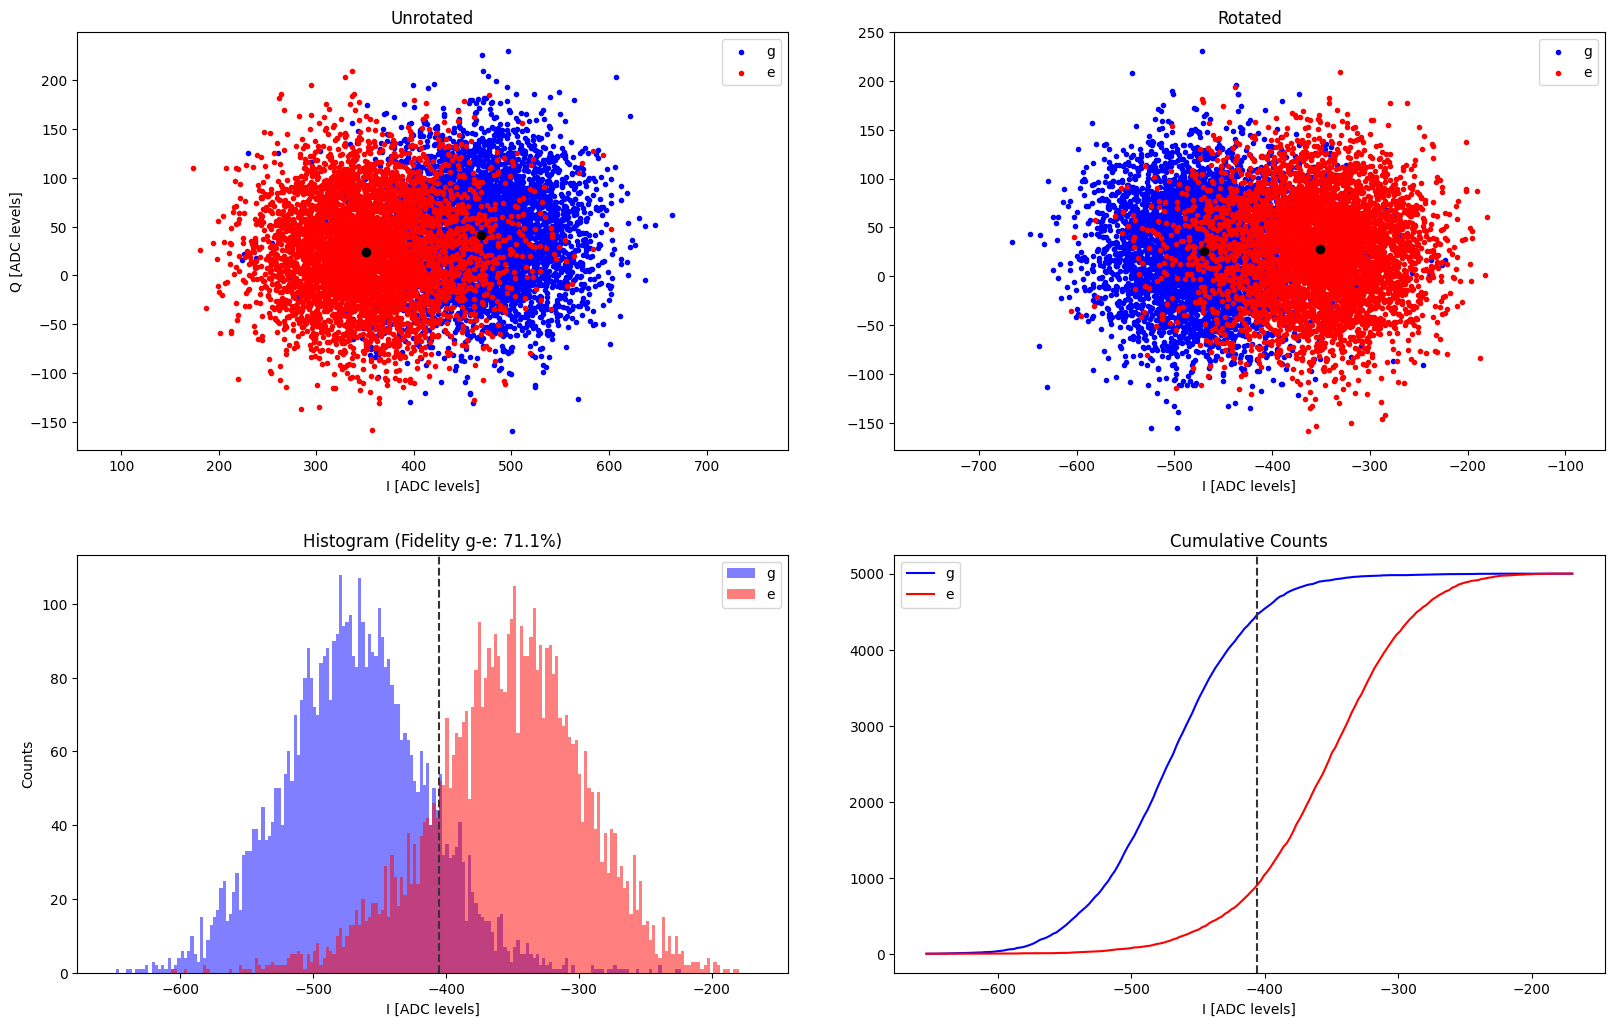

thresholds [0, [-405.3733906976022], 0, 0]
angles [0, 171.63437933988493, 0, 0]


  0%|          | 0/3 [00:00<?, ?it/s]

Total protocol time (us): None

// Program

        regwi 3, $21, 3441;                     //freq = 3441
        regwi 3, $22, 15;                       //mask = [0, 1, 2, 3]
        synci 200;
        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 4999;
LOOP_J: regwi 0, $21, 100;                      //freq = 100
        regwi 0, $22, 0;                        //phase = 0
        regwi 0, $24, 100;                      //gain = 100
        regwi 0, $25, 1638410;                  //phrst| stdysel | mode | | outsel = 0b11001 | length = 10 
        regwi 0, $26, 0;                        //t = 0
        set 0, 0, $21, $22, $0, $24, $25, $26;  //ch = 0, pulse @t = $26
        synci 7;
        regwi 1, $11, 100;                      //freq = 100
        regwi 1, $12, 0;                        //phase = 0
        regwi 1, $14, 100;                      //gain = 100
        regwi 1, $15, 1638410;                  //phrst| stdysel | mode | | outsel = 0b11001 | length = 10 
       

In [280]:
tomo = meas.StateTomography1QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"StateTomoQ{qubit}",
    config_file=config_path,
)

tomo.cfg.expt = dict(
    reps=5000, # reps per measurement basis
    qubit=qubit,
)

print(tomo.cfg)
tomo.go(analyze=False, display=False, progress=True, save=False)

## Run analysis

In [281]:
tomo = tomo
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00000_EgGf_state_tomo_01.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == meas_order)
assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

print('Tomography counts')
print(n_tomo)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(correct_readout_err(n_tomo, n_calib))
print('Negative counts corrected tomo matrix will be')
print(fix_neg_counts(correct_readout_err(n_tomo, n_calib)))

Tomography counts
[[1784. 3216.]
 [1616. 3384.]
 [1947. 3053.]]
Confusion matrix counts
[[4412.  588.]
 [ 857. 4143.]]
Confusion matrix corrected tomo matrix will be
[[1303.79747 3696.20253]
 [1067.51055 3932.48945]
 [1533.05204 3466.94796]]
Negative counts corrected tomo matrix will be
[[1304. 3696.]
 [1068. 3932.]
 [1533. 3467.]]


Generate test data

In [282]:
# n_tomo = generate_counts(qubits=qubits, rho_id=rho_id, n_tot=1000, noise=1)
# n_calib = qt.qeye(4).full()
# print(n_tomo)

Calculate ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [283]:
# psi_id = 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])
psi_id = (psiZ[0]+psiZ[1]).unit()
# psi_id = psiZ[1].unit()

rho_id = qt.ket2dm(psi_id)
print(rho_id)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]


##### Run MLE without ZZ correction

In [284]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE = run_MLE(n=correct_readout_err(n_tomo, n_calib), method='L-BFGS-B')
if rho_MLE is not None:
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE @ rho_MLE))
    print(f'Fidelity (no ZZ correction): {fid_base}')
    print(f'Purity (no ZZ correction): {purity_base}')

Fidelity (no ZZ correction): 0.2135017251213171
Purity (no ZZ correction): 0.8534345044057338


 <ipython-input-16-45aeffbdaf89>: 10ComplexWarning: Casting complex values to real discards the imaginary part
 <ipython-input-16-45aeffbdaf89>: 14

[[ 0.261+0.j    -0.286+0.193j]
 [-0.286-0.193j  0.739+0.j   ]]


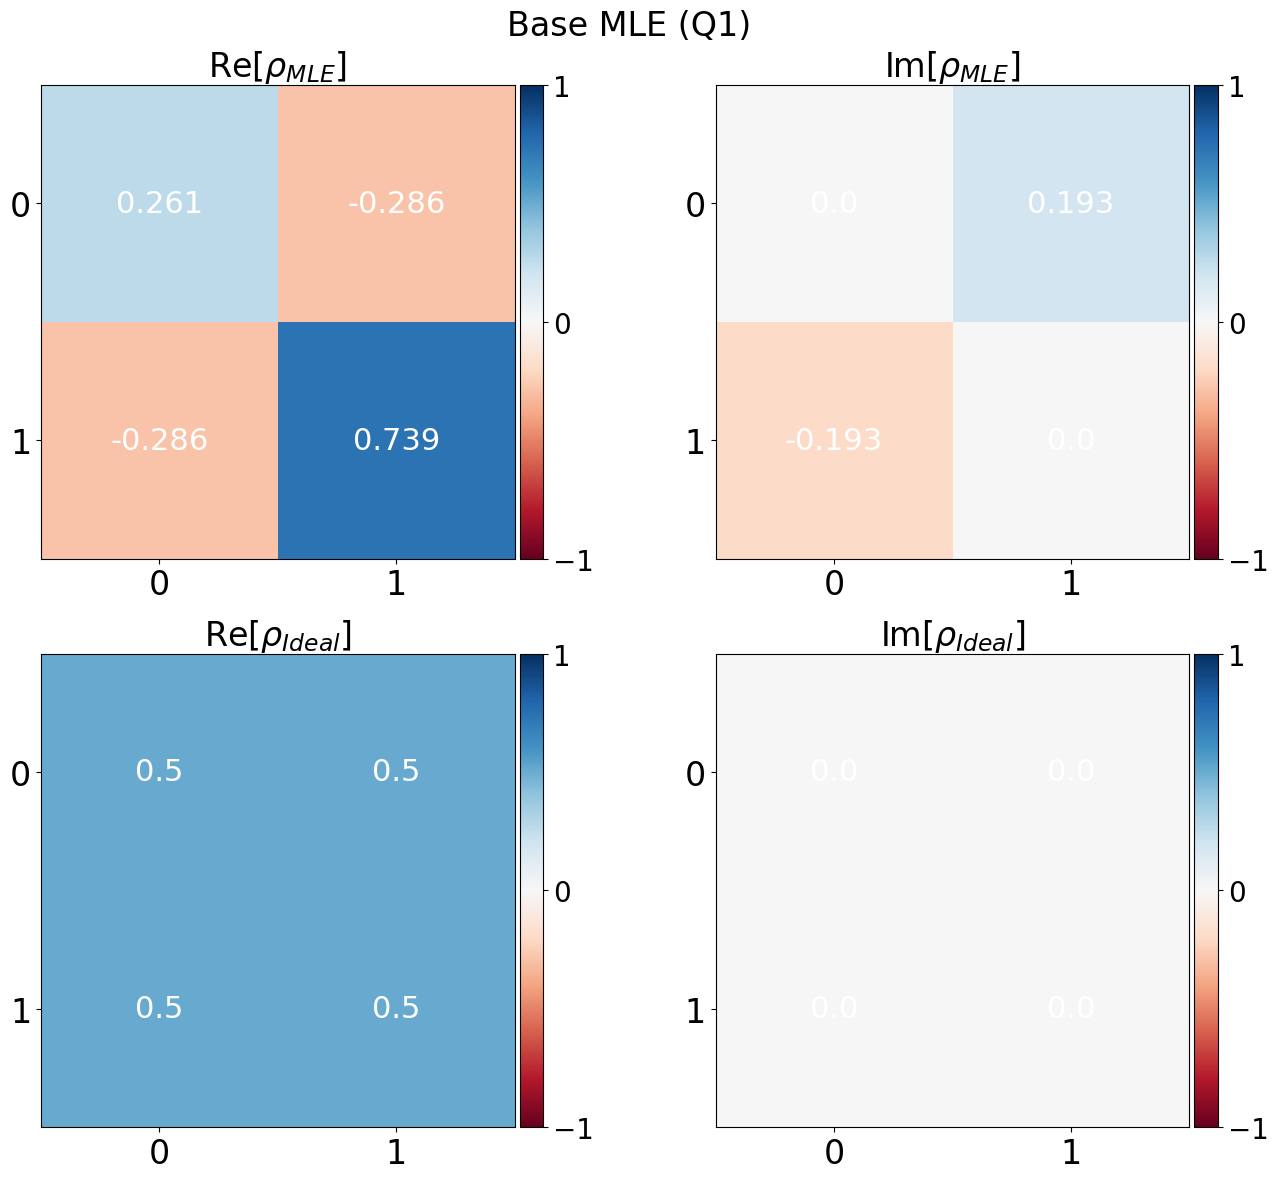

In [285]:
print(np.around(rho_MLE, decimals=3))
show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit})', cmax=1.0)

### Repeat over time

In [ ]:
import time

start_time = time.time()

all_n_tomo = []
all_n_calib = []
all_fids = []
times = []

psi_id = psiZ[1].unit()
rho_id = qt.ket2dm(psi_id)

while time.time() - start_time < 2*60*60:
    times.append(time.time()-start_time)
    tomo = meas.StateTomography1QExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"StateTomoQ{qubit}",
        config_file=config_path,
    )

    tomo.cfg.expt = dict(
        reps=5000, # reps per measurement basis
        qubit=qubit,
    )

    tomo.go(analyze=False, display=False, progress=False, save=False)

    data = tomo.data
    pulse_dict = tomo.pulse_dict
    assert np.all(np.array(tomo.meas_order) == meas_order)
    assert np.all(np.array(tomo.calib_order) == calib_order)

    n_tomo = np.array(data['counts_tomo'])
    n_calib = np.array(data['counts_calib'])

    all_n_tomo.append(n_tomo)
    all_n_calib.append(n_calib)

    rho_MLE = run_MLE(n=correct_readout_err(n_tomo, n_calib), method='L-BFGS-B')
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"

    all_fids.append(fid_base)
    print(fid_base)

    time.sleep(60)

In [64]:
print(all_fids)

[0.9952806509185746, 0.9912995566999999, 0.9911799005999988, 0.9953686333583277, 0.9940457160000005, 0.9859260461999994, 0.9939584918570085, 0.9887201021999997, 0.9937264571000014, 0.9355865122000016, 1.0, 0.8509444962999996, 0.9867390067005087, 0.9817200429, 0.9923941317093196, 0.9928132730118802, 0.9976155144999994, 0.9865801701252733, 0.9786605796514805, 0.9766657049999989, 0.9850704007144406, 0.9901406826999999, 0.9807799656999994, 0.9849562538000002, 0.9971639639600014, 0.9879132802999998, 0.9909516298000006, 0.9940603449743272, 0.7069164852721977, 0.9783648455130688, 1.0, 0.7508933782000009, 1.0, 0.9855914467999983, 0.9894701211101359, 0.9970160669151228, 0.9957239615000004, 0.976796086454644, 0.9959799256999992, 0.9912244863089081, 0.9842658021999995, 0.9878056839999989, 0.9876735890999994, 0.9909772354999996, 0.9943364113999988, 0.9947557343999983, 0.9882855789642206, 0.9942356372746803, 0.9807700137000009, 0.9960008189289044, 0.9794711874999987, 0.9962392720395592, 0.985225248

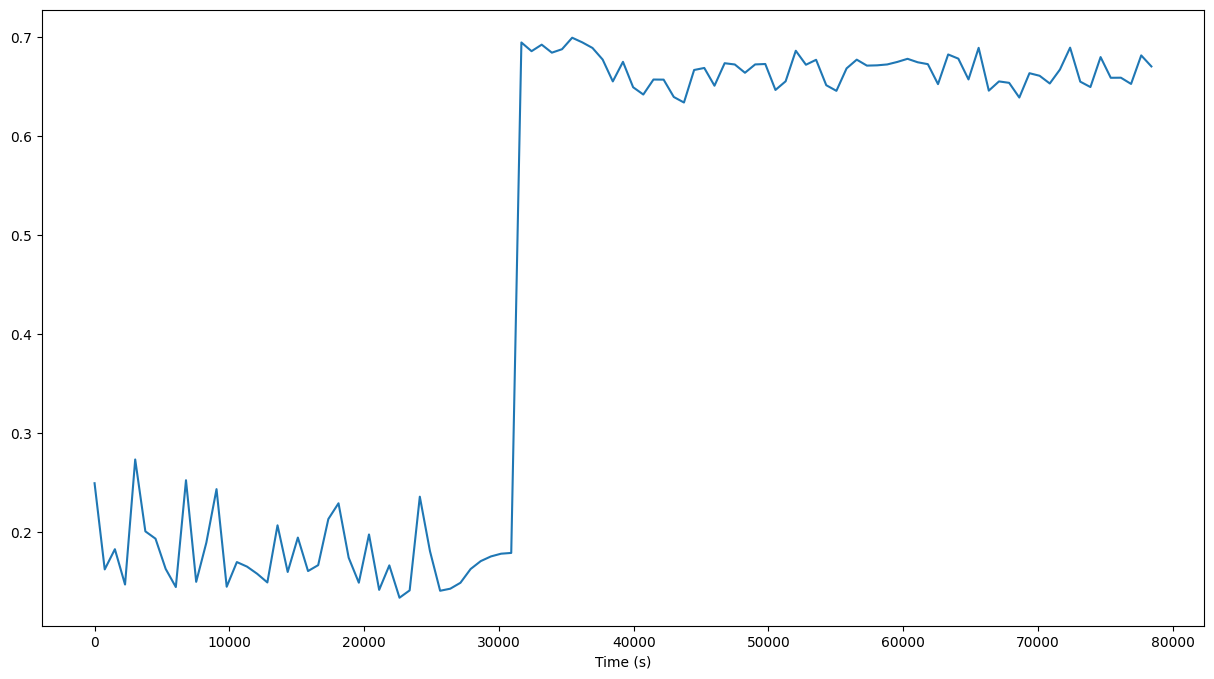

In [74]:
plt.figure(figsize=(15, 8))
plt.plot(times, all_fids)
plt.xlabel('Time (s)')
plt.show()